# Esercitazione 12: allenamento di una rete neurale per il riconoscimento di numeri scritti a mano

In [4]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adamax


seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

In [5]:
def TestOptim(optimizer):
    # training parameters
    batch_size = 32
    epochs = 15

    # create the deep neural net
    model_DNN = compile_model(optimizer)

    # train DNN and store training info in history
    history = model_DNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(X_test, Y_test))

    # evaluate model
    score = model_DNN.evaluate(X_test, Y_test, verbose=0)

    # print performance
    print()
    print('Optimizer:'+optimizer)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # summarize history for accuracy
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.legend(['train', 'test'], loc='best')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

L'obiettivo dell'esercizio 12 è utilizzare modelli di reti neurali profonde (DNN), implementati nel pacchetto Python Keras, per riconoscere e distinguere tra le dieci cifre scritte a mano (0-9).

#### Carico i dati di cifre scritte a mano

In [6]:
from tensorflow.keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)



X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


#### Definisco l'architettura della rete neurale

In [7]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Scelgo l'ottimizzatore e la funzione costo

In [8]:
def compile_model(optimizer):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Alleno il modello e valuto la performance sui dati di test per diversi ottimizzatori


Optimizer:sgd
Test loss: 0.08688274770975113
Test accuracy: 0.9718999862670898


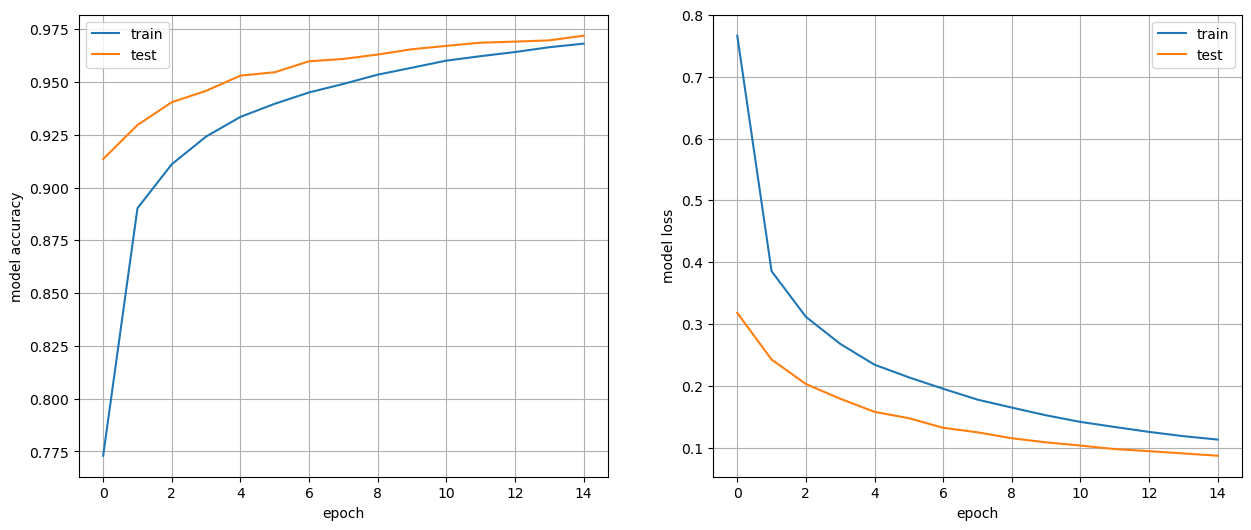

In [49]:
TestOptim('sgd')

#### Nota che l'accuratezza sul campione usato come test finale sembra essere addirittura maggiore rispetto a quella usata sul campione di allenamento, che dovrebbe invece essere massima. Questo è dovuto al fatto che le epoche usate sono troppo poche, se sono sufficienti definitivamente l'accuratezza sul campione di allenamento è massimizzata. Probabilmente la discesa stocastica del gradiente ci mette di più a convergere.


Optimizer:RMSprop
Test loss: 0.21771790087223053
Test accuracy: 0.9763000011444092


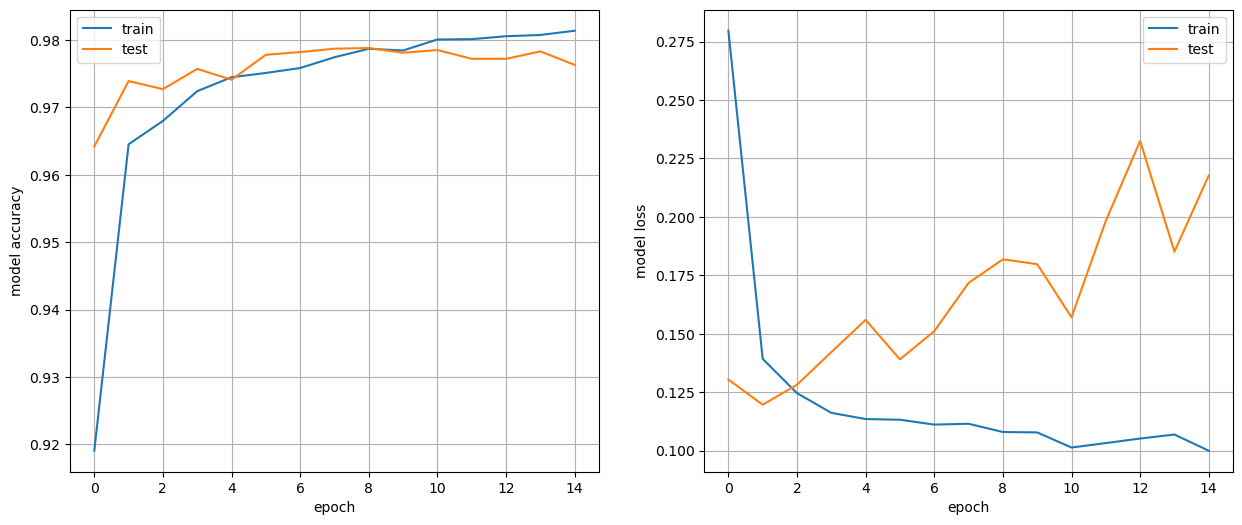

In [50]:
TestOptim('RMSprop')

#### L'accuratezza raggiunta sulle predizioni è altissima, del 98%.


Optimizer:Adam
Test loss: 0.11536422371864319
Test accuracy: 0.9807000160217285


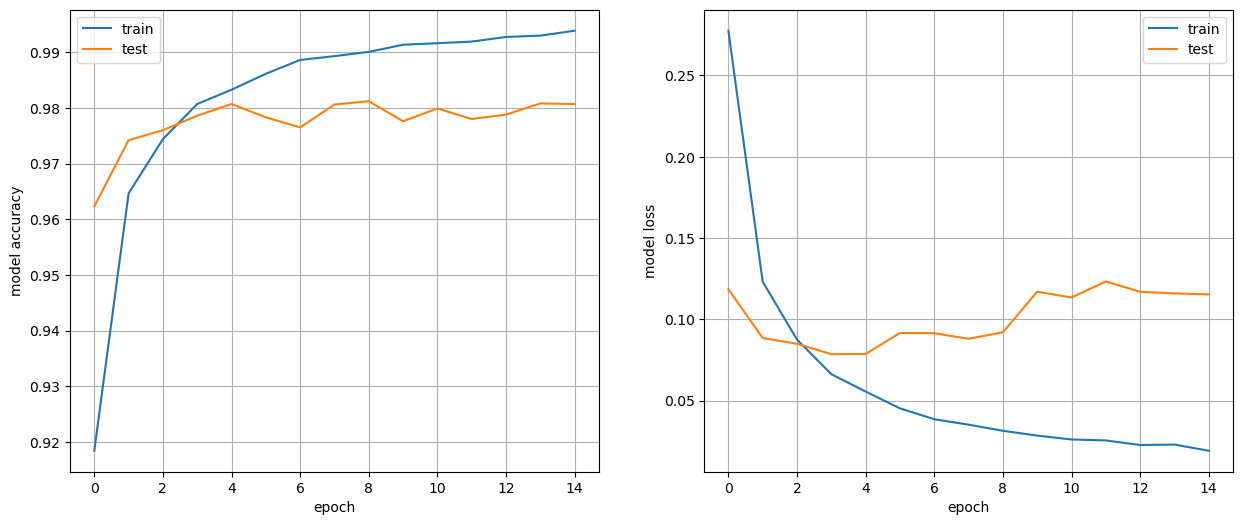

In [51]:
TestOptim('Adam')

Come possiamo vedere, tutti gli ottimizzatori testati hanno una buona accettazione finale (oltre il 97%) durante un periodo di allenamento piuttosto lungo (15 epoche di allenamento).

L'sgd ha la forma più regolare sia per la loss che per l'accuratezza e raggiunge un valore molto basso (0.086) per la funzione di loss. Anche l'Adam ha un buon valore finale di loss (0.098), ma si osserva un aumento della funzione di loss sul test che attraversa quella di train. RMSprop è il peggiore, con oscillazioni più elevate e il valore finale di loss più alto (0.288), ottenuto da un aumento della funzione di loss di train dopo la quarta epoca.

# Reti neurali convoluzionali e riconoscimento di cifre

Considerando le immagini delle cifre scritte a mano nel dataset MNIST, è evidente che esistono correlazioni spaziali locali tra i pixel. Finora abbiamo rappresentato i dati del MNIST come vettori 1D di lunghezza 28x28. Tuttavia, potremmo ottenere risultati migliori sfruttando le caratteristiche spaziali, ad esempio prendendo in considerazione le **correlazioni tra i pixel e l'invarianza traslazionale** durante l'elaborazione delle immagini.

Una rete neurale gode infatti di invarianza traslazionale, cioè è invariante rispetto a qualunque permutazione degli input. Rompendo questa invarianza, è possibile inserire livelli convoluzionali che tengono conto delle caratteristiche locali dell'immagine e accelerano la convergenza.

Modificheremo quindi il codice dell'esercizio precedente, aggiornando l'architettura della rete attraverso l'implementazione dei convolutional layers. Utilizzeremo layers come:

- Conv2D: questo layer convoluzionale produce un'ulteriore layer 2D basandosi sul layer precedente.
- Dropout: questo layer spegne casualmente alcuni neuroni per rendere più difficile l'apprendimento e irrobustire il modello.
- MaxPooling2D: riduce l'immagine in input selezionando il valore massimo di un pixel all'interno di una finestra di dimensioni fissate.
- Flatten: questo layer appiattisce l'input, trasformandolo da 2D a 1D, in modo da poter strutturare l'architettura con layer densi.
- Soft-max: viene applicato alla fine, per fornire output netti.


In [9]:
# you will need the following for Convolutional Neural Networks
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [10]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first layer
    model.add(Conv2D(6, kernel_size=(5, 5), \
                     activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    #add second layer
    model.add(Conv2D(16, kernel_size=(5, 5), \
                     activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #add flatten
    model.add(Flatten())
    #add last but one layer          
    model.add(Dense(256, activation='relu'))
    #add last softmax layer
    model.add(Dense(10, activation='softmax'))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, \
                  optimizer='SGD', metrics=['accuracy'])
    return model

In [11]:
# training parameters
batch_size = 32
epochs = 5

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/home/daniele/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-14 15:19:32.895343: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/5


2024-05-14 15:19:33.270884: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5905 - loss: 1.2116 - val_accuracy: 0.9510 - val_loss: 0.2675
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9050 - loss: 0.3028 - val_accuracy: 0.9643 - val_loss: 0.1698
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9306 - loss: 0.2251 - val_accuracy: 0.9732 - val_loss: 0.1309
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9429 - loss: 0.1851 - val_accuracy: 0.9784 - val_loss: 0.1013
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9481 - loss: 0.1676 - val_accuracy: 0.9807 - val_loss: 0.0946

Test loss: 0.0945536196231842
Test accuracy: 0.9807000160217285


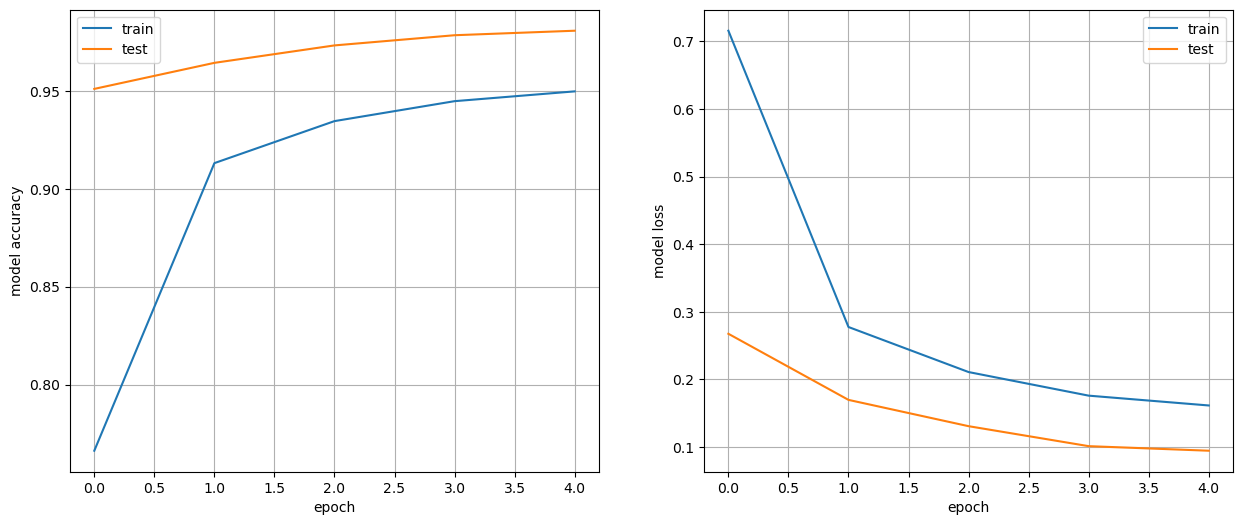

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


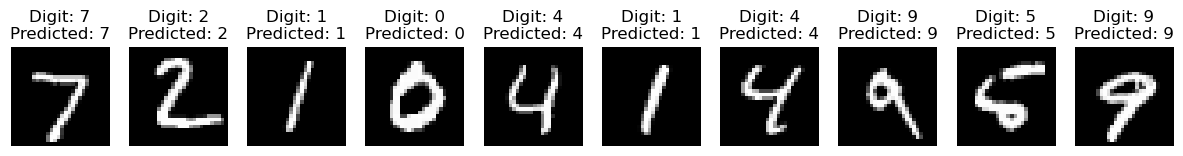

In [12]:
# summarize history for accuracy
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='best')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='best')
plt.show()

#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Come si può vedere, la rete neurale convoluzionale con questa configurazione ha una buona capacità predittiva.

#### Carico cifre scritte a mano

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


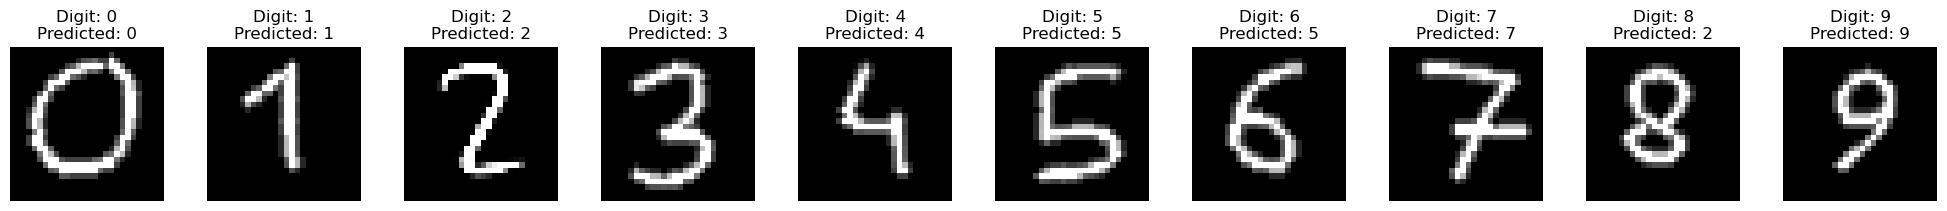

In [13]:
from PIL import Image
import os

plt.figure(figsize=(25,2))

for digit in range(10):

    digit_filename = "numeri/"+str(digit)+"_test.png"
    digit_in = Image.open(digit_filename).convert('L')

    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255

    plt.subplot(1, 10, digit+1)
    
    plt.imshow(data, cmap='gray')
    
    data = data.reshape(1, xdim*ydim)
    
    # reshape data, depending on Keras backend
    if keras.backend.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
        
    pred_0 = model_CNN.predict(data)
    
    plt.title("Digit: {}\nPredicted: {}".format(digit, np.argmax(pred_0)))
    plt.axis('off')
plt.show()

La rete neurale riconosce tutte le cifre che ho scritto, fatta eccezione per il 7, dato che è stata allenata su un 7 senza stanghetta in mezzo.